In [1]:
!pip install tensorflow==2.15.0
!pip install tensorflow-privacy==0.8.9
!pip install tensorflow-estimator==2.15.0

  Using cached tensorflow_privacy-0.8.9-py3-none-any.whl.metadata (772 bytes)
  Using cached attrs-21.4.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached dp_accounting-0.4.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached immutabledict-2.2.5-py3-none-any.whl.metadata (3.2 kB)
  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached parameterized-0.9.0-py2.py3-none-any.whl.metadata (18 kB)
  Using cached tensorflow_probability-0.15.0-py2.py3-none-any.whl.metadata (13 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached mpmath-1.2.1-py3-none-any.whl.metadata (8.3 kB)
INFO: pip is looking at multiple versions of dp-accounting to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install tensorflow-privacy and tensorflow-privacy==0.8.9 because these package versions have conflicting dependencies.

The conflict is caused by:
    tensorflow-pr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import tensorflow as tf
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers import dp_optimizer_keras

import os
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [3]:
data_v1 = pd.read_csv('athletes.csv')
print(data_v1.shape)
print(data_v1.head())

(423006, 27)
   athlete_id           name               region          team  \
0      2554.0      Pj Ablang           South West   Double Edge   
1      3517.0  Derek Abdella                  NaN           NaN   
2      4691.0            NaN                  NaN           NaN   
3      5164.0    Abo Brandon  Southern California  LAX CrossFit   
4      5286.0    Bryce Abbey                  NaN           NaN   

              affiliate gender   age  height  weight   fran  ...  snatch  \
0  Double Edge CrossFit   Male  24.0    70.0   166.0    NaN  ...     NaN   
1                   NaN   Male  42.0    70.0   190.0    NaN  ...     NaN   
2                   NaN    NaN   NaN     NaN     NaN    NaN  ...     NaN   
3          LAX CrossFit   Male  40.0    67.0     NaN  211.0  ...   200.0   
4                   NaN   Male  32.0    65.0   149.0  206.0  ...   150.0   

   deadlift  backsq  pullups  \
0     400.0   305.0      NaN   
1       NaN     NaN      NaN   
2       NaN     NaN      NaN   

In [4]:
data = data_v1.copy()

# Remove not relevant columns
data = data.dropna(subset=['region','age','weight','height','howlong','gender','eat', \
                           'train','background','experience','schedule','howlong', \
                           'deadlift','candj','snatch','backsq','experience',\
                           'background','schedule','howlong'])
data = data.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',\
                          'filthy50','fgonebad','run400','run5k','pullups','train'])

# Remove Outliers

data = data[data['weight'] < 1500]
data = data[data['gender'] != '--']
data = data[data['age'] >= 18]
data = data[(data['height'] < 96) & (data['height'] > 48)]

data = data[(data['deadlift'] > 0) & (data['deadlift'] <= 1105)|((data['gender'] == 'Female') \
             & (data['deadlift'] <= 636))]
data = data[(data['candj'] > 0) & (data['candj'] <= 395)]
data = data[(data['snatch'] > 0) & (data['snatch'] <= 496)]
data = data[(data['backsq'] > 0) & (data['backsq'] <= 1069)]

# Clean Survey Data

decline_dict = {'Decline to answer|': np.nan}
data = data.replace(decline_dict)
data = data.dropna(subset=['background','experience','schedule','howlong','eat'])

data_v2 = data

In [5]:
print(data_v2.shape)
print(data_v2.head())

(30029, 14)
                 region gender   age  height  weight  candj  snatch  deadlift  \
21  Southern California   Male  30.0    71.0   200.0  235.0   175.0     385.0   
22               Africa   Male  28.0    70.0   176.0  187.0   134.0     335.0   
27           North East   Male  35.0    68.0   225.0  285.0   205.0     440.0   
50        North Central   Male  36.0    71.0   199.0  267.0   212.0     485.0   
60           North East   Male  36.0    64.0   155.0  245.0   180.0     415.0   

    backsq                                                eat  \
21   315.0                      I eat whatever is convenient|   
22   254.0               I eat 1-3 full cheat meals per week|   
27   405.0  I eat quality foods but don't measure the amount|   
50   390.0  I eat quality foods but don't measure the amount|   
60   385.0                                I eat strict Paleo|   

                                           background  \
21  I played youth or high school level sports|I p...

In [6]:
data_v1['total_lift'] = (data_v1['deadlift'] + data_v1['candj'] + data_v1['snatch'] + data_v1['backsq'])

data_v2['total_lift'] = (data_v2['deadlift'] + data_v2['candj'] + data_v2['snatch'] + data_v2['backsq'])

In [7]:
data_v1.to_csv('athletes_v1.csv', index=False)
data_v2.to_csv('athletes_v2.csv', index=False)

           deadlift         candj        snatch        backsq    total_lift
count  1.153230e+05  1.044350e+05  9.728000e+04  1.105170e+05  8.519100e+04
mean   6.970503e+02  2.709107e+02  2.424957e+02  5.852109e+02  2.061057e+03
std    5.523235e+04  2.596882e+04  2.708942e+04  5.052976e+04  1.548460e+05
min   -5.000000e+02 -4.500000e+01  0.000000e+00 -7.000000e+00 -2.200000e+01
25%    2.550000e+02  1.400000e+02  1.050000e+02  2.050000e+02  7.330000e+02
50%    3.450000e+02  1.950000e+02  1.450000e+02  2.750000e+02  9.850000e+02
75%    4.150000e+02  2.350000e+02  1.850000e+02  3.350000e+02  1.185000e+03
max    8.388607e+06  8.388607e+06  8.388607e+06  8.388607e+06  3.355443e+07


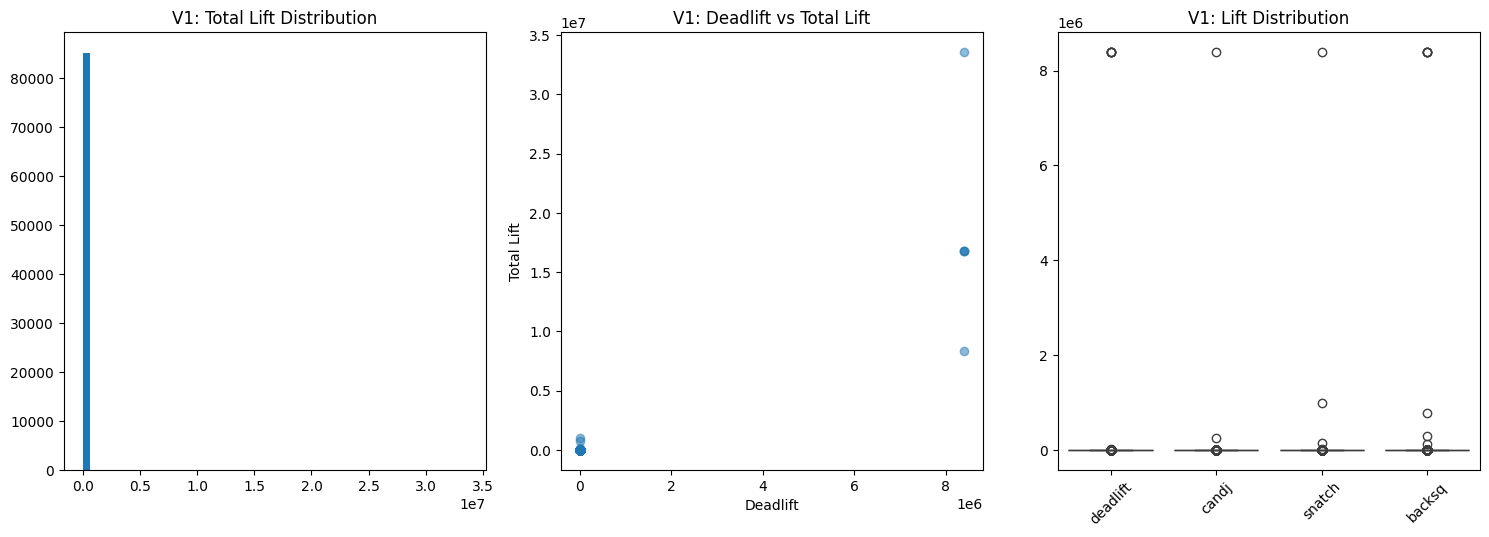

In [8]:
# eda for data_v1
print(data_v1[['deadlift','candj','snatch','backsq','total_lift']].describe())

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(data_v1['total_lift'], bins=50)
plt.title('V1: Total Lift Distribution')

plt.subplot(2, 3, 2)
plt.scatter(data_v1['deadlift'], data_v1['total_lift'], alpha=0.5)
plt.xlabel('Deadlift')
plt.ylabel('Total Lift')
plt.title('V1: Deadlift vs Total Lift')

plt.subplot(2, 3, 3)
sns.boxplot(data=data_v1[['deadlift','candj','snatch','backsq']])
plt.title('V1: Lift Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

           deadlift         candj        snatch        backsq    total_lift
count  30029.000000  30029.000000  30029.000000  30029.000000  30029.000000
mean     361.933997    205.418396    156.174198    294.118818   1017.645409
std       96.745441     58.687508     48.833572     85.081340    277.682895
min        0.000000      1.000000      1.000000      1.000000      4.000000
25%      287.000000    160.000000    120.000000    225.000000    805.000000
50%      375.000000    205.000000    155.000000    300.000000   1040.000000
75%      434.000000    245.000000    190.000000    355.000000   1224.000000
max     1000.000000    390.000000    386.000000    882.000000   2135.000000


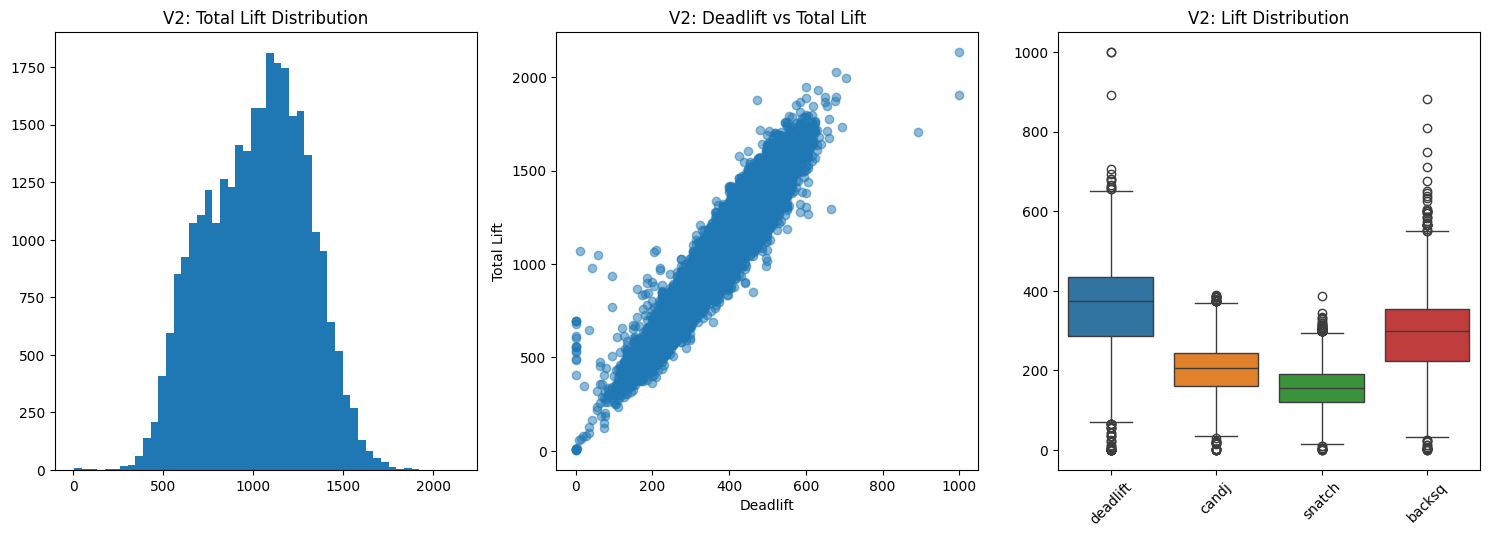

In [9]:
# eda for data_v2
print(data_v2[['deadlift','candj','snatch','backsq','total_lift']].describe())

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(data_v2['total_lift'], bins=50)
plt.title('V2: Total Lift Distribution')

plt.subplot(2, 3, 2)
plt.scatter(data_v2['deadlift'], data_v2['total_lift'], alpha=0.5)
plt.xlabel('Deadlift')
plt.ylabel('Total Lift')
plt.title('V2: Deadlift vs Total Lift')

plt.subplot(2, 3, 3)
sns.boxplot(data=data_v2[['deadlift','candj','snatch','backsq']])
plt.title('V2: Lift Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [10]:
print(data_v1.columns.tolist())

['athlete_id', 'name', 'region', 'team', 'affiliate', 'gender', 'age', 'height', 'weight', 'fran', 'helen', 'grace', 'filthy50', 'fgonebad', 'run400', 'run5k', 'candj', 'snatch', 'deadlift', 'backsq', 'pullups', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong', 'total_lift']


In [11]:
data_v1.select_dtypes(include=[np.number]).columns.tolist()

['athlete_id',
 'age',
 'height',
 'weight',
 'fran',
 'helen',
 'grace',
 'filthy50',
 'fgonebad',
 'run400',
 'run5k',
 'candj',
 'snatch',
 'deadlift',
 'backsq',
 'pullups',
 'total_lift']

In [12]:
numeric_cols = ['age', 'weight', 'height', 'deadlift', 'candj', 'snatch', 'backsq']
available_cols = [col for col in numeric_cols if col in data_v1.columns]

X_v1 = data_v1[available_cols].select_dtypes(include=[np.number])
y_v1 = data_v1['total_lift']

valid_idx = ~(X_v1.isnull().any(axis=1) | y_v1.isnull())
X_v1 = X_v1[valid_idx]
y_v1 = y_v1[valid_idx]

X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_v1, y_v1, test_size=0.2, random_state=42)

print(X_train_v1.shape)
print(X_test_v1.shape)

(59228, 7)
(14808, 7)


In [13]:
model_v1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_v1.fit(X_train_v1, y_train_v1)

y_pred_v1 = model_v1.predict(X_test_v1)

mse_v1 = mean_squared_error(y_test_v1, y_pred_v1)
r2_v1 = r2_score(y_test_v1, y_pred_v1)
mae_v1 = mean_absolute_error(y_test_v1, y_pred_v1)

print(f"MSE: {mse_v1:.2f}")
print(f"R2: {r2_v1:.4f}")
print(f"MAE: {mae_v1:.2f}")

MSE: 106112159.15
R2: 0.9944
MAE: 88.28


In [14]:
X_v2 = data_v2[available_cols].select_dtypes(include=[np.number])
y_v2 = data_v2['total_lift']

valid_idx = ~(X_v2.isnull().any(axis=1) | y_v2.isnull())
X_v2 = X_v2[valid_idx]
y_v2 = y_v2[valid_idx]

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

print(X_train_v2.shape)
print(X_test_v2.shape)

(24023, 7)
(6006, 7)


In [15]:
model_v2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_v2.fit(X_train_v2, y_train_v2)

y_pred_v2 = model_v2.predict(X_test_v2)

mse_v2 = mean_squared_error(y_test_v2, y_pred_v2)
r2_v2 = r2_score(y_test_v2, y_pred_v2)
mae_v2 = mean_absolute_error(y_test_v2, y_pred_v2)

print(f"MSE: {mse_v2:.2f}")
print(f"R2: {r2_v2:.4f}")
print(f"MAE: {mae_v2:.2f}")

MSE: 170.21
R2: 0.9978
MAE: 4.37


In [16]:
print(f"V1 - MSE: {mse_v1:.2f}, R2: {r2_v1:.4f}, MAE: {mae_v1:.2f}")
print(f"V2 - MSE: {mse_v2:.2f}, R2: {r2_v2:.4f}, MAE: {mae_v2:.2f}")

improvement_mse = ((mse_v1 - mse_v2) / mse_v1) * 100
improvement_r2 = ((r2_v2 - r2_v1) / r2_v1) * 100

print(f"MSE changed: {improvement_mse:.2f}%")
print(f"R2 changed: {improvement_r2:.2f}%")

V1 - MSE: 106112159.15, R2: 0.9944, MAE: 88.28
V2 - MSE: 170.21, R2: 0.9978, MAE: 4.37
MSE changed: 100.00%
R2 changed: 0.34%


In [17]:
# TensorFlow
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_v2)
X_test_scaled = scaler_X.transform(X_test_v2)
y_train_scaled = scaler_y.fit_transform(y_train_v2.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test_v2.values.reshape(-1, 1)).flatten()

X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)
y_train_scaled = y_train_scaled.astype(np.float32)
y_test_scaled = y_test_scaled.astype(np.float32)

l2_norm_clip = 1.0
noise_multiplier = 0.8
learning_rate = 0.001
batch_size = 32

optimizer = dp_optimizer_keras.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=1,
    learning_rate=learning_rate
)

model_dp = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model_dp.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model_dp.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=batch_size, verbose=1, validation_data=(X_test_scaled, y_test_scaled), callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/30
751/751 [==============================] - 6s 4ms/step - loss: 0.6162 - mae: 0.6010 - val_loss: 0.1190 - val_mae: 0.2687
Epoch 2/30
751/751 [==============================] - 3s 4ms/step - loss: 0.2075 - mae: 0.3388 - val_loss: 0.0430 - val_mae: 0.1577
Epoch 3/30
751/751 [==============================] - 4s 6ms/step - loss: 0.1738 - mae: 0.3084 - val_loss: 0.0340 - val_mae: 0.1402
Epoch 4/30
751/751 [==============================] - 3s 4ms/step - loss: 0.1565 - mae: 0.2914 - val_loss: 0.0239 - val_mae: 0.1168
Epoch 5/30
751/751 [==============================] - 2s 3ms/step - loss: 0.1359 - mae: 0.2700 - val_loss: 0.0228 - val_mae: 0.1143
Epoch 6/30
751/751 [==============================] - 3s 3ms/step - loss: 0.1270 - mae: 0.2604 - val_loss: 0.0234 - val_mae: 0.1194
Epoch 7/30
751/751 [==============================] - 3s 4ms/step - loss: 0.1211 - mae: 0.2539 - val_loss: 0.0199 - val_mae: 0.1066
Epoch 8/30
751/751 [==============================] - 4s 5ms/step - loss: 0.

In [18]:
y_pred_dp_scaled = model_dp.predict(X_test_scaled)
y_pred_dp = y_pred_dp_scaled * y_train_v2.std() + y_train_v2.mean()

mse_dp = mean_squared_error(y_test_v2, y_pred_dp.flatten())
r2_dp = r2_score(y_test_v2, y_pred_dp.flatten())
mae_dp = mean_absolute_error(y_test_v2, y_pred_dp.flatten())

print(f"MSE: {mse_dp:.2f}")
print(f"R2: {r2_dp:.4f}")
print(f"MAE: {mae_dp:.2f}")

188/188 [==============================] - 0s 2ms/step
MSE: 926.75
R2: 0.9879
MAE: 23.99


In [19]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

# Parameters
epochs_actual = len(history.history['loss'])

epsilon, _ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
    n=X_train_v2.shape[0],
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=epochs_actual,
    delta=1e-5
)

print(f"epsilon = {epsilon:.3f}")

epsilon = 1.840


In [20]:
# compare non-DP and DP
print(f"non-DP - MSE: {mse_v2:.2f}, R2: {r2_v2:.4f}, MAE: {mae_v2:.2f}")
print(f"DP - MSE: {mse_dp:.2f}, R2: {r2_dp:.4f}, MAE: {mae_dp:.2f}")

privacy_cost_mse = ((mse_dp - mse_v2) / mse_v2) * 100
privacy_cost_r2 = ((r2_v2 - r2_dp) / r2_v2) * 100

print(f"MSE change: {privacy_cost_mse:.2f}%")
print(f"R2 change: {privacy_cost_r2:.2f}%")

non-DP - MSE: 170.21, R2: 0.9978, MAE: 4.37
DP - MSE: 926.75, R2: 0.9879, MAE: 23.99
MSE change: 444.47%
R2 change: 0.99%
